In [3]:
# Cell 1: Imports and Configuration
import os
import shutil
import sys
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import insightface
from insightface.app import FaceAnalysis
from insightface.model_zoo import get_model

# --- Configuration ---
SOURCE_ROOT = "dataset/images"
DEST_DIR = "processed_dataset"
TRAIN_DIR = os.path.join(DEST_DIR, "train")
EVAL_DIR = os.path.join(DEST_DIR, "eval")
SPLIT_RATIO = 0.8
FINETUNED_MODEL_PATH = "finetuned_model.pth"

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32

print("All libraries imported and configurations are set.")

All libraries imported and configurations are set.


In [4]:
# Cell 2: Crucial - Environment Verification
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print("-" * 30)
is_cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {is_cuda_available}")

if is_cuda_available:
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CUDA is not available. The script will run on the CPU, which will be very slow.")

# This MUST print True before you continue.
# If it prints False, stop and fix your PyTorch installation.

Python Version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
PyTorch Version: 2.5.1+cu121
------------------------------
CUDA Available: True
GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
# Cell 3: Dataset Preparation
# (This code is from prepare_dataset.py)

if os.path.exists(DEST_DIR):
    print(f"'{DEST_DIR}' already exists. Skipping dataset preparation.")
else:
    print("Starting dataset preparation...")
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(EVAL_DIR, exist_ok=True)
    
    for person_name in os.listdir(SOURCE_ROOT):
        person_source_path = os.path.join(SOURCE_ROOT, person_name)
        if not os.path.isdir(person_source_path): continue
        all_person_images = []
        for quality_folder in os.listdir(person_source_path):
            quality_path = os.path.join(person_source_path, quality_folder)
            if os.path.isdir(quality_path):
                for img_name in os.listdir(quality_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        all_person_images.append(os.path.join(quality_path, img_name))
        if not all_person_images: continue
        train_files, eval_files = train_test_split(all_person_images, train_size=SPLIT_RATIO, random_state=42)
        person_train_path = os.path.join(TRAIN_DIR, person_name)
        person_eval_path = os.path.join(EVAL_DIR, person_name)
        os.makedirs(person_train_path, exist_ok=True)
        os.makedirs(person_eval_path, exist_ok=True)
        for f in train_files: shutil.copy(f, person_train_path)
        for f in eval_files: shutil.copy(f, person_eval_path)
    print(f"✅ Dataset splitting complete! Output is in '{DEST_DIR}'")

'processed_dataset' already exists. Skipping dataset preparation.


In [6]:
# Cell 4: Helper Functions

# --- Evaluation & Plotting ---
def run_evaluation(model_app, eval_dir, embedding_function):
    print(f"Running evaluation on folder: {eval_dir}")
    filepaths, labels = [], []
    for person_name in sorted(os.listdir(eval_dir)):
        person_path = os.path.join(eval_dir, person_name)
        if not os.path.isdir(person_path): continue
        for img_name in os.listdir(person_path):
            filepaths.append(os.path.join(person_path, img_name))
            labels.append(person_name)

    embeddings = [embedding_function(model_app, fp) for fp in filepaths]
    valid_indices = [i for i, emb in enumerate(embeddings) if emb is not None]
    embeddings = [embeddings[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    
    y_true, y_score = [], []
    for i, j in itertools.combinations(range(len(labels)), 2):
        similarity = np.dot(embeddings[i], embeddings[j])
        y_score.append(similarity)
        y_true.append(1 if labels[i] == labels[j] else 0)
    return np.array(y_true), np.array(y_score)

def get_embedding_pretrained(model_app, image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    faces = model_app.get(img)
    return faces[0].normed_embedding if len(faces) > 0 else None

def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# --- Fine-Tuning ---
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = [], []
        self.class_to_idx = {}
        for idx, person_name in enumerate(sorted(os.listdir(root_dir))):
            person_path = os.path.join(root_dir, person_name)
            if not os.path.isdir(person_path): continue
            self.class_to_idx[person_name] = idx
            for img_name in os.listdir(person_path):
                self.image_paths.append(os.path.join(person_path, img_name))
                self.labels.append(idx)
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform: image = self.transform(image)
        return image, label

print("✅ Helper functions are defined.")

✅ Helper functions are defined.


--- Starting Baseline Evaluation ---


c:\Users\vishn\AppData\Local\Programs\Python\Python310\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\vishn/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\vishn/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\vishn/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\vishn/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\vishn/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

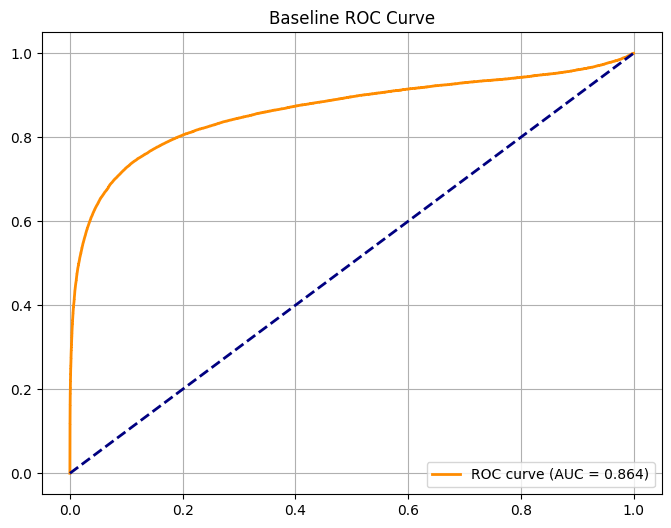

In [7]:
# Cell 5: Step 1 - Baseline Evaluation
print("--- Starting Baseline Evaluation ---")
pretrained_model = FaceAnalysis(name='buffalo_l')
pretrained_model.prepare(ctx_id=0, det_size=(640, 640))

y_true_base, y_score_base = run_evaluation(
    model_app=pretrained_model,
    eval_dir=EVAL_DIR,
    embedding_function=get_embedding_pretrained
)

plot_roc_curve(y_true_base, y_score_base, title='Baseline ROC Curve')

In [8]:
# New Cell: Verify and Clean Image Data
import os
from PIL import Image

def find_bad_images(root_dir):
    bad_files = []
    print(f"Verifying images in: {root_dir}")
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                filepath = os.path.join(dirpath, filename)
                try:
                    with Image.open(filepath) as img:
                        img.verify()  # This checks for file integrity
                except Exception as e:
                    print(f"Found bad file: {filepath} | Reason: {e}")
                    bad_files.append(filepath)
    return bad_files

# Find all corrupted images
bad_train_files = find_bad_images(TRAIN_DIR)
bad_eval_files = find_bad_images(EVAL_DIR)
all_bad_files = bad_train_files + bad_eval_files

if not all_bad_files:
    print("\n✅ All images seem to be valid!")
else:
    print(f"\nFound {len(all_bad_files)} bad files.")

    # --- UNCOMMENT THE LINES BELOW TO DELETE ALL BAD FILES ---
    print("Deleting bad files...")
    for f in all_bad_files:
         os.remove(f)
    print("✅ Deletion complete.")

Verifying images in: processed_dataset\train
Verifying images in: processed_dataset\eval

✅ All images seem to be valid!


In [9]:
# Cell 6: Step 2 - Model Fine-Tuning
print("\n--- Starting Model Fine-Tuning ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# IMPORTANT: Before running this cell, make sure you've cleared the cache
# by deleting the C:\Users\vishn\.insightface\models\ folder
# This will force a fresh download of the 'r50' model.

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = FaceDataset(root_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
num_classes = len(train_dataset.class_to_idx)
print(f"Found {num_classes} identities for training.")

# Load a pre-trained backbone (PyTorch ResNet50)
from torchvision.models import resnet50

model = resnet50(pretrained=True)
embedding_size = model.fc.in_features
model.fc = nn.Linear(embedding_size, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
print(f"✅ Fine-tuning complete. Model saved to {FINETUNED_MODEL_PATH}")


--- Starting Model Fine-Tuning ---
Using device: cuda
Found 8 identities for training.


c:\Users\vishn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vishn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Loss: 0.6736
Epoch [2/15], Loss: 0.3274
Epoch [3/15], Loss: 0.2533
Epoch [4/15], Loss: 0.2112
Epoch [5/15], Loss: 0.1674
Epoch [6/15], Loss: 0.1476
Epoch [7/15], Loss: 0.1324
Epoch [8/15], Loss: 0.1111
Epoch [9/15], Loss: 0.1016
Epoch [10/15], Loss: 0.0864
Epoch [11/15], Loss: 0.0820
Epoch [12/15], Loss: 0.0725
Epoch [13/15], Loss: 0.0679
Epoch [14/15], Loss: 0.0577
Epoch [15/15], Loss: 0.0537
✅ Fine-tuning complete. Model saved to finetuned_model.pth


--- Starting Re-evaluation of Fine-Tuned Model ---
Loading fine-tuned model from: finetuned_model.pth


c:\Users\vishn\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vishn\AppData\Local\Temp\ipykernel_29228\186425345.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

Running evaluation on folder: processed_dataset\eval


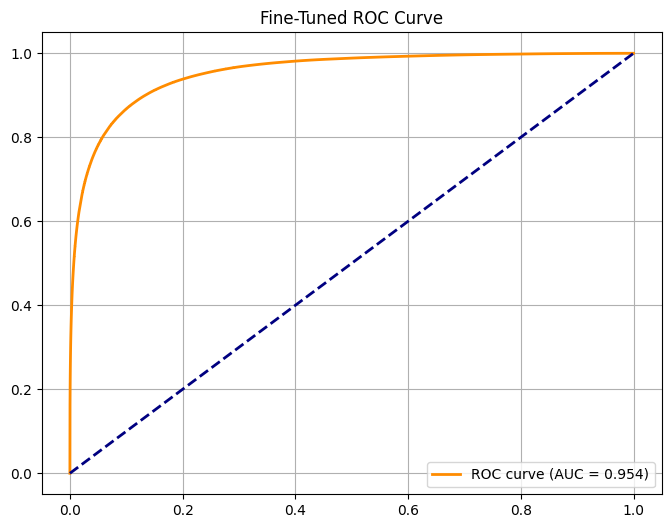

In [10]:
# Cell 7: Step 3 - Re-evaluation of Fine-Tuned Model
print("--- Starting Re-evaluation of Fine-Tuned Model ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper functions to load the fine-tuned model and get embeddings ---
def load_finetuned_model(model_path, num_classes, embedding_size):
    """Loads the fine-tuned PyTorch model backbone for embedding extraction."""
    print(f"Loading fine-tuned model from: {model_path}")
    from torchvision.models import resnet50
    model = resnet50(pretrained=False)
    model.fc = nn.Linear(embedding_size, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    # We want the features before the final classification layer
    model.fc = nn.Identity()
    model.to(device)
    model.eval()
    return model

def get_embedding_finetuned(model, image_path):
    """Extracts an embedding using the fine-tuned PyTorch model."""
    transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    try:
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(img_tensor).cpu().numpy().flatten()
            norm = np.linalg.norm(embedding)
            return embedding / norm
    except Exception:
        return None

# --- Run the evaluation ---
# Note: num_classes and embedding_size are variables from the previous cell (Cell 6)
finetuned_backbone = load_finetuned_model(FINETUNED_MODEL_PATH, num_classes, embedding_size)

y_true_ft, y_score_ft = run_evaluation(
    model_app=finetuned_backbone,
    eval_dir=EVAL_DIR,
    embedding_function=get_embedding_finetuned
)

plot_roc_curve(y_true_ft, y_score_ft, title='Fine-Tuned ROC Curve')



In [11]:
# New Cell: Check Working Directory
import os
print(f"The notebook's current working directory is: {os.getcwd()}")

The notebook's current working directory is: d:\face_recognition


In [12]:
# New Cell: Find a Good Example for Figure 3

# First, we need to regenerate the list of file paths from the evaluation set
# This must match the order used during the evaluation runs
eval_filepaths = []
for person_name in sorted(os.listdir(EVAL_DIR)):
    person_path = os.path.join(EVAL_DIR, person_name)
    if not os.path.isdir(person_path): continue
    for img_name in os.listdir(person_path):
        eval_filepaths.append(os.path.join(person_path, img_name))

# Now, we search through the results to find a pair that improved significantly
print("Searching for a pair of images that shows clear improvement...")
found_example = False
pair_indices = list(itertools.combinations(range(len(eval_filepaths)), 2))

for i in range(len(y_true_base)): # y_true_base has the same length as the number of pairs
    # Condition 1: It must be a pair of images of the same person
    if y_true_base[i] == 1:
        
        # Condition 2: The baseline model failed (score is low)
        baseline_failed = y_score_base[i] < 0.4 
        
        # Condition 3: The fine-tuned model succeeded (score is high)
        finetuned_succeeded = y_score_ft[i] > 0.6
        
        if baseline_failed and finetuned_succeeded:
            pair_index = pair_indices[i]
            image1_path = eval_filepaths[pair_index[0]]
            image2_path = eval_filepaths[pair_index[1]]
            
            print("\n✅ Found a great example for Figure 3!")
            print(f"Image 1 Path: {image1_path}")
            print(f"Image 2 Path: {image2_path}")
            print(f"Baseline Score (failed): {y_score_base[i]:.3f}")
            print(f"Fine-Tuned Score (succeeded): {y_score_ft[i]:.3f}")
            
            found_example = True
            break # Stop after finding the first good example

if not found_example:
    print("\nCould not find a perfect example with the current thresholds. Try adjusting the score values (e.g., < 0.5 and > 0.5).")

Searching for a pair of images that shows clear improvement...

✅ Found a great example for Figure 3!
Image 1 Path: processed_dataset\eval\Firoz\a (105).png
Image 2 Path: processed_dataset\eval\Firoz\a (136).png
Baseline Score (failed): 0.393
Fine-Tuned Score (succeeded): 0.967
